# Molecular Dynamics using the Velocity-Verlet Algorithm
# By: Anthony Lazos

## Introduction

When analyzing systems that include many particle, the usual way to determine meaningful quantities is to use statistical mechanics to find average values such as kinetic energy and bulk properties such as temperature. In this way, intermolecular forces are usually ignored and each particle is assumed to be a hard point mass, such as an ideal gas. When intermolecularforces are considered, the problem is reduced to only two or three particles for simple calcualtions. With molecular dynamic simulations, however, it is possible to have a large number of particles while still accounting for intermolecular forces and we would expect to see the ideal assumotions hold at high temperatures when kinetic energy is far greater than potential. The potential typically used for molecular dynamic simulations is the Lennard-Jones(LJ) potential:

$$U(r) = 4\epsilon \cdot \big(\big(\frac{\sigma}{r}\big)^{12} - \big(\frac{\sigma}{r}\big)^6\big) $$

Where $\epsilon$ represents the strength of the Van der Waal forces between particles and the exact number is the depth of the potential well. Whereas $\sigma$ represents the 'size' of the atom. Below this distance, the electron clouds of the particles begin to overlap and, because we assume there is no bonding, they particles are forced apart because of Pauli repulsion. Above this distance, Van der Waal forces attract the particles to each other. The repulsive force is much stronger, which is reflected in the potential equation by having an exponent of 12 whereas the attraction term only has an exponent of 6.

The key of these simulations is knowing what the $\sigma$ and $\epsilon$ values are for various atoms.

Maghfiroh, C.Y. et al. (2019) used the LJ potential along with the Large-scale Atomic/Molecular Massively Parallel Simulator (LAMMPS) in order to determine $\sigma$ and $\epsilon$ values for Fe, Pb, Ni and Cr. To do this, they set the system to the known melting point of the metal and then varied $\sigma$ and $\epsilon$ until they had parameters that showed a phase change from solid to liquid.

Filippova, V.P. et al. (2015) also tried to determine $\sigma$ and $\epsilon$ for $\alpha$-Fe, Cr, V, Mo, $\alpha$-W, Al, Ni, and Cu. However, they took an analytic approach to first calcualte the LJ potential for face cented and body centered cubic crystal structures, and then used their derivations to solve for $\sigma$ and $\epsilon$ values for identical atoms when setting the system at the melting point temperature of the specific metal.

These two studies had only chromium in common and obtained different values for its $\sigma$ and $\epsilon$. Maghfiroh found that $\sigma=2.781Å$ and $\epsilon = 0.243eV$ while Filippova found that $\sigma = 2.281Å$ and $\epsilon = 0.673eV$. The values are close, but even with the given errors, the experiments do not show the same results. Hopfully, this project will be able to show that either of these pairs of values works.

Elliott & Akerson (2015), as part of the Open Knowledgebase of Interatomic Models (OpenKIM) project, have compiled a list of $\sigma$s and $\epsilon$s from hydrogen(1) to Oganesson(118) based on the work of many other researchers, all of which are creditied on thier list for further insight to the techniques of each experiment. For some examples, I will be taking values from from this list.

The goal of this project is to create a molecular dynamics simulation and be able to visualize and calcualte the effects of various combinations of $\sigma$ and $\epsilon$ values. Hopfully, with this we can find similar values that previous research has.

## Implementation
The outline for the implementation method for this simulation came from Computational Physics: Problem Solving with Python by Rubin Landau.

We can calculate the force created by taking the derivitive of the LJ potential with respect to r.

$$F(r) = \frac{48\epsilon}{r} \cdot \big(\big(\frac{\sigma}{r}\big)^{12} - \frac{1}{2}\big(\frac{\sigma}{r}\big)^6\big)$$

Then to calculate the motion of each atom, we use the Velocity-Verlet algorithm.

$$r(t+dt) = r(t) + v(t)dt + \frac{F(t)}{2}dt^2$$

$$v(t+dt) = v(t) + \frac{F(t+dt) + F(t)}{2}dt$$

Notice that the velocity depends on the current and future force. Therefore, the order of calcualtion using this algorithm is to first set initial values, calculate all forces, update positions, calcualte all forces again, then update the velocity. All calculations are repeted in this order, except for the initialization, for each time step.

Other features of this simulation include:

-A cutoff distance of 2.5$\sigma$. At this distnace the potential is essentially zero, so it is safe to ignore calcualtions further than that to save computing time. This does create a discontinuous potential, so some energy may be lost, but it will be negligable.

-The 'box' that the particles exist in is infinite. That is, they interact with each other across the boundaries and will reappear on the opposite side of the box if they drift too far away. This is to simulate an 'infinite' number of particles where they are not constrained by the walls of a physical box. This is useful for imagining these particles in a region of the atosphere or as a small part of a larger latice, for example.

-Initial velocities are set by using monte carlo aceptance/rejection method from a  Maxwell-Boltzmann distribution at a given temperature.

Currently, the code will produce only cubes, with equal spacing in the x, y, and z directions for simplicity. There are comments thoughout noting where this can be changed and the box size is coded such that the separation distance between particles is constant, even across boundries.

The simulation can then be run in a 3D model to watch all the atoms. The motion can also simply be calculated and the important information will be plotted. 

Let's begin! (This will go most smoothly if you run each cell in order. If an output ever looks horribly wrong rerun the associated initilization and try again.)

### Imports
Importing the necessary packages.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from numpy import random
import pint
%matplotlib notebook

### Units
Natural or SI units can be used. This sets all the units needed to convert from convenient inputs to SI units.

In [3]:
ureg = pint.UnitRegistry(system='mks')

global g, kg, amu, cm, m, A, K, J, eV, s, fs

# Mass
g = ureg.sys.SI.gram
kg = ureg.sys.SI.kilogram
amu = ureg.sys.atomic.amu

# Length
cm = ureg.sys.SI.centimeter
m = ureg.sys.SI.meter
A = ureg.sys.atomic.angstrom

# Temperature
K = ureg.sys.atomic.kelvin

# Energy
J = ureg.sys.SI.joule
eV = ureg.sys.atomic.electron_volt

# Time
s = ureg.sys.SI.second
fs = ureg.sys.SI.femtosecond

### The Main Implimentation
This is the bulk of what was described above. The comments explain what is happening and where the interesting things to change are.

In [4]:
def init(Lx,Ly,Lz,initvel='no'):
    """
    Calcualtes all the starting parameters such as position, velocity, and the size of the box.
    """
    ###########################  Look Here  ########################################
    # spacing can be changed in each dimension to be what ever you want (as long as its constant per dimension).
    xs = ys = zs = spacing
    ################################################################################
    xmin = ymin = zmin = 0
    
    # temporary, makes all the x and y values
    x = np.arange(0,nx)*xs+xmin
    y = np.arange(0,ny)*ys+ymin
    z = np.arange(0,nz)*zs+zmin
    
    xm = np.mean(x); ym = np.mean(y); zm = np.mean(z)
    
    x = x-xm+Lx/2
    y = y-ym+Ly/2
    z = z-zm+Lz/2
    
    # makes uniform spacing about the center of the grid
    Lx = np.max(x) + spacing/2 - np.min(x) - spacing/2
    Lx = np.max(x) + spacing/2 - np.min(x) - spacing/2
    Lx = np.max(x) + spacing/2 - np.min(x) - spacing/2

    # combines all the combinations in a grid
    x, y, z = np.meshgrid(x,y,z)
    # makes it 1d bc the rest of the code needs 1d arrays
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()
    
    # zero arrays for initial velocity and forces
    vx = np.zeros(len(x)); fx0 = np.zeros(len(x)); fx1 = np.zeros(len(x))
    vy = np.zeros(len(y)); fy0 = np.zeros(len(y)); fy1 = np.zeros(len(y))
    vz = np.zeros(len(z)); fz0 = np.zeros(len(z)); fz1 = np.zeros(len(z))
    
    if len(x) != len(y) != len(z):
        print('Something went wrong with the number of particles.')
    
    # if not starting the particles from rest
    # start velocities according to maxwell boltzmann distribution
    if initvel == 'yes':
        
        maxv = np.sqrt(2 * kb * temp / mass)
        maxprob = boltzmann(maxv)
        
        i=0
        while i < len(x):
            j = 1
            V = 0
            ###########################  Look Here  ########################################
            # This is to get an average of many trials of velocities to make the distribution more accurate 
            # with a small number of particles.
            # In testing, I tried for j <= 1e5 with 4^3 particles, but the runtime was too long.
            # For less dramatic increases, to 500 for example, slightly more accurate initial velocities were created. 
            # I set j to 100 here to show the results without excessive runtimes.
            while j <= 100:
            ################################################################################
                # acceptance/rejection to get velocities
                testprob = random.uniform(0,maxprob)
                testV = random.uniform(0,maxv)

                if testprob < boltzmann(testV):
                    V = V + testV
                    j += 1
            
            # take the average and square it
            V2 = (V/j)**2 # v^2 = vx^2 + vy^2 + vz^2

            # randomly split v^2 into three parts
            while True:
                split1 = random.uniform(0,V2)
                split2 = random.uniform(split1,V2)
                if split1 != split2:
                    break

            # assign the sqrt of those to vx, vy, vz
            sign = []
            for k in range(3): 
                sign.append(random.choice([-1,1]))
            vx[i] = sign[0]*np.sqrt(split1)
            vy[i] = sign[1]*np.sqrt(split2-split1)
            vz[i] = sign[2]*np.sqrt(V2-split2)
            i += 1

    return x,y,z,vx,vy,vz,fx0,fy0,fz0,fx1,fy1,fz1

def boltzmann(v):
    """
    Maxwell-Boltzmann distribution for particle velocities.
    """
    c = mass/(2*kb*temp)
    return (c/np.pi)**(3/2) * 4 * np.pi * v**2 * np.exp(-c * v**2)

def sign(a,b):
    """
    Makes particles only interact with the closest image of a particle.
    """
    if b >= 0:
        return np.abs(a)
    else:
        return -np.abs(a)

def F(x,y,z):
    """
    Calculates the position and force and potential associated with that position for each particle.
    """
    fx0 = np.zeros(len(x))
    fy0 = np.zeros(len(y))
    fz0 = np.zeros(len(z))
    U = 0
    
    # component by component
    for i in range(len(x)):
        for j in range(len(x)):
            if i == j:
                pass # skip canclulating the force with itself
            else:
                dx = x[i] - x[j]
                dy = y[i] - y[j]
                dz = z[i] - z[j]

                if (np.abs(dx) > 0.5*Lx):
                    dx = dx - sign(Lx,dx)
                if (np.abs(dy) > 0.5*Ly):
                    dy = dy - sign(Ly,dy)
                if (np.abs(dz) > 0.5*Lz):
                    dz = dz - sign(Lz,dz)

                r = np.sqrt(dx**2 + dy**2 + dz**2)
                if r < rcut:
                    if r == 0:
                        print("r=0?")
                        r = 0.000001 # avoid divide by 0, but really this should never happen since were skipping the diagonal
                    f = 48*eps/r * ( (sig/r)**12 - 0.5*(sig/r)**6 )
                    U = U + 4*eps * ( (sig/r)**12 - (sig/r)**6 )

                    fx0[i] = fx0[i] + f*dx/r
                    fy0[i] = fy0[i] + f*dy/r
                    fz0[i] = fz0[i] + f*dz/r
                
        
    return fx0,fy0,fz0,U/2

def KE(vx,vy,vz):
    """
    Calculates total kinetic energy.
    """
    return np.sum((vx**2+vy**2+vz**2)/2 * mass)

# update position
def nextpos(e,v,f0):
    """
    Updates the particles to the next position.
    """
    for i in range(len(e)):
        e[i] = e[i] + dt*v[i] + dt**2 * f0[i]/2

# update velocity
def nextvel(v,f1,f0):
    """
    Updates the particles' velocity.
    """
    for i in range(len(v)):
        v[i] = v[i] + dt*(f1[i]+f0[i])/2

# apply boundry
def boundary(x,y,z):
    """
    Applies boundary to keep all particles within the initial box.
    """
    for i in range(len(x)):
        if not 0 <= x[i] < Lx:
            x[i] %= Lx
            
    for i in range(len(y)):
        if not 0 <= y[i] < Ly:
            y[i] %= Ly
                   
    for i in range(len(z)):
        if not 0 <= z[i] < Lz:
            z[i] %= Lz


# Constants

In [5]:
def constants(nx,ny,nz,m,s,e,steps,sys):
    """
    Sets all the constants needed for the calcualtions and converts to SI units if necessary.
    """
    global kb, mass, sig, eps, rcut, Lx, Ly, Lz, dt, time_interval
    if sys == 'kms':    
        # true constants
        kb = ((1 * ureg.sys.atomic.boltzmann_constant).to_base_units()).magnitude
        
        # times
        dt = ((10 * fs).to_base_units()).magnitude
        endtime = steps * dt
        time_interval = np.arange(0, endtime, dt)

        # particle properties
        mass = ((m * amu).to_base_units()).magnitude # in amu
        sig = ((s * A).to_base_units()).magnitude # in Angstrom. This is the 'size of the atom'. Distance at which force = 0.
        eps = ((e * eV).to_base_units()).magnitude # in eV. This is the strength of the interaction
        rcut = 2.5*sig
        
        Lx = spacing * nx + spacing/2
        Ly = spacing * ny + spacing/2
        Lz = spacing * nz + spacing/2
        
    if sys == 'natural':
        # true constants
        kb = 1

        # times
        dt = 0.004
        endtime = steps * dt
        time_interval = np.arange(0, endtime, dt)

        # particle properties
        mass = m
        sig = s
        eps = e
        rcut = 2.5*sig

        Lx = spacing * nx + spacing/2
        Ly = spacing * ny + spacing/2
        Lz = spacing * nz + spacing/2

## Results

First, in natural units, we can observe the effects of various values of sigma and epsilon. The values shown here are good represnetation and run smoothly with minimal runtime. All the values can be changed, but beware increasing the particle number by too much, or maybye just avoid running the 3D model if you want a lot of particles.

In [6]:
random.seed(100) # the seed for consistancy
nx = ny = nz = 3 # the cube will have n^3 particles
m = 1 # mass
s = 1 # sigma, Also try with s = 1000 and e =1 
e = 1 # epsilon
global spacing; spacing = s # particle spacing
global temp;    temp    = 20     # Initial temperature
steps = 5000 # steps to take
sys='natural' # natural vs kilogram, meter, second
initvel = 'no' # use starting velocities. 'yes' or 'no'
constants(nx,ny,nz,m,s,e,steps,sys)
start = init(Lx,Ly,Lz,initvel)
x   = start[0]; y   = start[1]; z   = start[2] 
vx  = start[3]; vy  = start[4]; vz  = start[5]
fx0 = start[6]; fy0 = start[7]; fz0 = start[8]
fx1 = start[9]; fy1 = start[10]; fz1 = start[11]

Be aware that the motion is calculated within the animate function, so even when the timer resets the particles are unaffected. The time is there to give a sense of how fast time is pasing, not to be a measure of the absolute time passed.

<IPython.core.display.Javascript object>


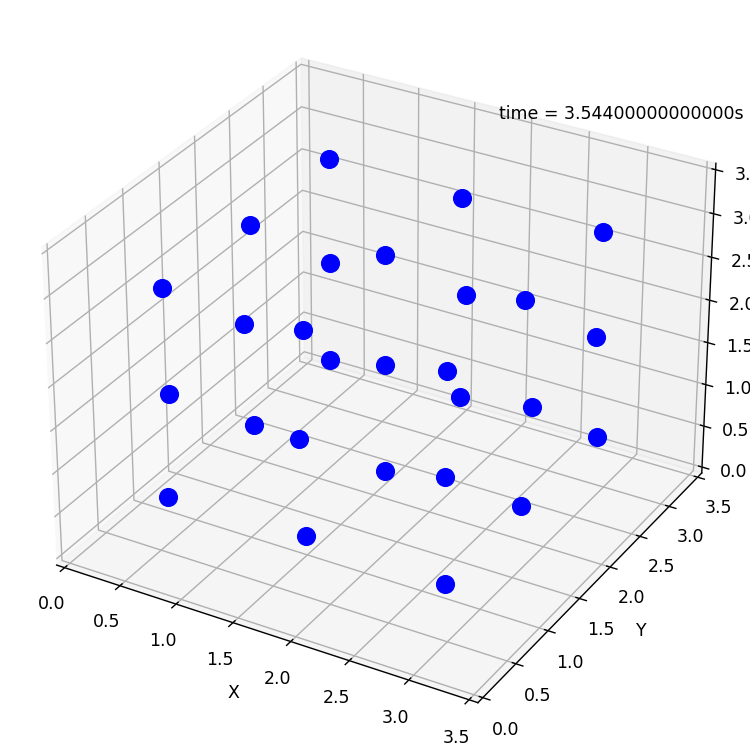

In [7]:
fig = plt.figure(figsize=[6,6])
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.set_xlim3d([0, Lx]); ax.set_xlabel('X')
ax.set_ylim3d([0, Ly]); ax.set_ylabel('Y')
ax.set_zlim3d([0, Lz]); ax.set_zlabel('Z') 
ax.grid()

A_marker, = ax.plot([], [], [], 'o', markersize=10, color='blue')

time_template = 'time = %.14fs'
time_text = ax.text(Lx/2, Ly, Lz+1e-10, '')

def animate(i):  
    A_marker.set_data( x,y )
    A_marker.set_3d_properties( z )

    f0 = F(x,y,z);fx0 = f0[0]; fy0 = f0[1]; fz0 = f0[2]
    nextpos(x,vx,fx0)
    nextpos(y,vy,fy0)
    nextpos(z,vz,fz0)
    boundary(x,y,z)
    f1 = F(x,y,z); fx1 = f1[0]; fy1 = f1[1]; fz1 = f1[2]
    nextvel(vx,fx1,fx0)
    nextvel(vy,fy1,fy0)
    nextvel(vz,fz1,fz0)

    time_text.set_text(time_template % (i*dt))
    return A_marker, time_text,

ani = matplotlib.animation.FuncAnimation(fig, animate, np.arange(1, 1000),
                                         interval=10, blit=False) # change interval if it's lagging
plt.show()

Notice how after sometime the latice falls apart and particle begin moving around randomly. This is because the initial conditions were not the equalibrium conditions for the system. After trying many combinations, I couldn't find one that created a stable latice. However, increasing $\sigma$ made the latice stay together longer, while increaseing $\epsilon$ made it fall apart faster. So, I could keep the latice together for a while with a large $\sigma$ and small $\epsilon$, but when looking at the energies in the section below, I found that that to did eventually fall apart. Try with $s=1000$ and $e=1$ as commented in the code to see this.

Now lets look at the plot for this. This code below is the same initilization as two cells up, but needs to be run again to set the particles back in the correct initial spots. This will be true thoughout; everytime you run the simulation you will need to rerun the set up before running it again. Otherwise, the particles will start where they left off in the last run.

In [43]:
random.seed(100) # the seed for consistancy
nx = ny = nz = 3 # the cube will have n^3 particles
m = 1 # mass
s = 1 # sigma, Also try with s=1000 and e = 1
e = 1 # epsilon
global spacing; spacing = s # particle spacing
global temp;    temp    = 20     # Initial temperature
########################################################################
steps = 5000 # steps to take, And increase this to 10000 steps when s=1000
########################################################################
sys='natural' # natural vs kilogram, meter, second
initvel = 'no' # use starting velocities. 'yes' or 'no'
constants(nx,ny,nz,m,s,e,steps,sys)
start = init(Lx,Ly,Lz,initvel)
x   = start[0]; y   = start[1]; z   = start[2] 
vx  = start[3]; vy  = start[4]; vz  = start[5]
fx0 = start[6]; fy0 = start[7]; fz0 = start[8]
fx1 = start[9]; fy1 = start[10]; fz1 = start[11]

This is the same math used in the animation with some additions. Here we calso calculate potential, kinetic, and total energy and temperature. Unlike the animation this will only go until it reaches the specified end time which is controlled by the number of steps above. Change that if you'd like to see a longer plot.

The output from this tracts the time and temperature and the x-component of the position and velocity of 1 particle throughout its trajectory.

In [44]:
U = np.zeros(len(time_interval))
ke = np.zeros(len(time_interval))
E = np.zeros(len(time_interval))
f0 = F(x,y,z)

for i in range(len(time_interval)):
    if i%100 == 0:
        aveke = mass*np.sum(vx**2+vy**2+vz**2)/(2*len(x)) # average kinetic energy
        T = 2/3 * aveke / (len(x)*kb) # Temperature of the system given by statistics
        print("Time: {:.3f}  Temp: {:.4f}  x: {:.4f}  vx: {:.4f}".format(time_interval[i], T, x[0], vx[0]))
        print('-----------------------------------------------')

    fx0 = f0[0]; fy0 = f0[1]; fz0 = f0[2]
    U[i] = f0[3]
    ke[i] = KE(vx,vy,vz)
    E[i] = U[i]+ke[i]
    nextpos(x,vx,fx0)
    nextpos(y,vy,fy0)
    nextpos(z,vz,fz0)
    boundary(x,y,z)
    f1 = F(x,y,z); fx1 = f1[0]; fy1 = f1[1]; fz1 = f1[2]
    nextvel(vx,fx1,fx0)
    nextvel(vy,fy1,fy0)
    nextvel(vz,fz1,fz0)
    f0 = np.copy(f1)
    
print('Done!')

Time: 0.000  Temp: 0.0000  x: 0.7500  vx: 0.0000
-----------------------------------------------
Time: 0.400  Temp: 0.0435  x: 0.6798  vx: 1.3255
-----------------------------------------------
Time: 0.800  Temp: 0.0474  x: 0.5555  vx: 1.4692
-----------------------------------------------
Time: 1.200  Temp: 0.0248  x: 0.4881  vx: -0.5908
-----------------------------------------------
Time: 1.600  Temp: 0.0481  x: 0.5967  vx: -1.5794
-----------------------------------------------
Time: 2.000  Temp: 0.0211  x: 0.7273  vx: -1.3254
-----------------------------------------------
Time: 2.400  Temp: 0.0201  x: 0.8108  vx: 0.9760
-----------------------------------------------
Time: 2.800  Temp: 0.0169  x: 0.4968  vx: -0.4520
-----------------------------------------------
Time: 3.200  Temp: 0.0385  x: 0.7661  vx: -0.0360
-----------------------------------------------
Time: 3.600  Temp: 0.0360  x: 0.6211  vx: 1.4125
-----------------------------------------------
Time: 4.000  Temp: 0.0161

Here is the energy vs time plot for the run. This is added spearetly so the plot can be adjusted without needing to rerun the math each time.

<IPython.core.display.Javascript object>


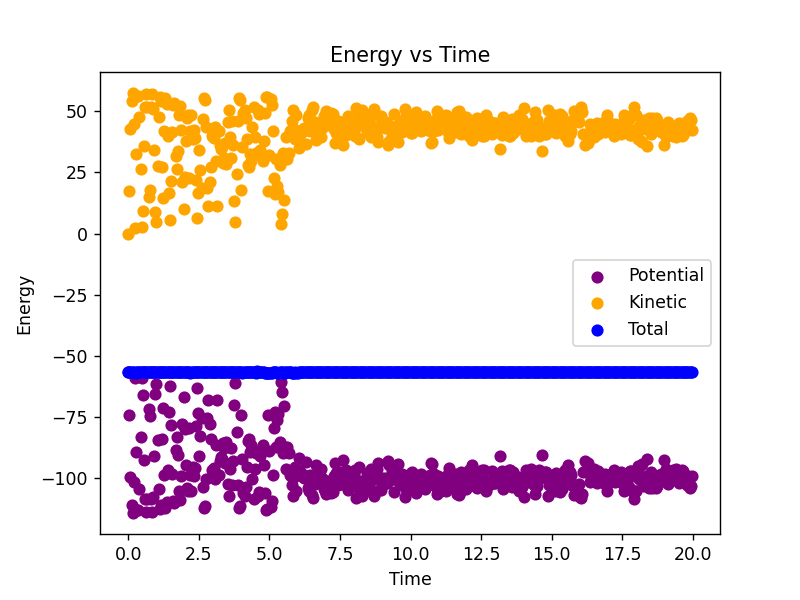

In [48]:
space = 10 # plots every given number of points. If this equals 2, it plots every point
plt.figure()
plt.scatter(time_interval[::space],U[::space],color='purple',label='Potential')
plt.scatter(time_interval[::space],ke[::space],color='orange',label='Kinetic')
plt.scatter(time_interval[::space],E[::space],color='blue',label='Total')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Energy vs Time")
plt.show()

The simulation produces a great result! Most importantly, total energy is conserved! We see that although the round off error makes us lose some energy, it isn't enough to see a noticeable difference. We also notice that the potential and kinetic energies are inconsistant at the begining but after about 6 seconds, they both flatten out. This means the system has come to an equilibrium. You can change to $s=1000$, $e=1$, and $steps=10000$ to see a more gradual increase in kinetic energy over a longer time and total energy will still conserved. 

We can repeat this, but this time giving the system some initial velocity. I won't plot the 3D model from now on, but its available to copy and paste if you'd like.

In [231]:
random.seed(100) # the seed for consistancy
nx = ny = nz = 3 # the cube will have n^3 particles
m = 1 # mass
s = 1 # sigma
e = 1 # epsilon
global spacing; spacing = s # particle spacing
global temp;    temp    = 20     # Initial temperature
steps = 5000 # steps to take
sys='natural' # natural vs kilogram, meter, second
initvel = 'yes' # use starting velocities. 'yes' or 'no'
constants(nx,ny,nz,m,s,e,steps,sys)
start = init(Lx,Ly,Lz,initvel)
x   = start[0]; y   = start[1]; z   = start[2] 
vx  = start[3]; vy  = start[4]; vz  = start[5]
fx0 = start[6]; fy0 = start[7]; fz0 = start[8]
fx1 = start[9]; fy1 = start[10]; fz1 = start[11]

In [232]:
U = np.zeros(len(time_interval))
ke = np.zeros(len(time_interval))
E = np.zeros(len(time_interval))
f0 = F(x,y,z)

for i in range(len(time_interval)):
    if i%100 == 0:
        aveke = mass*np.sum(vx**2+vy**2+vz**2)/(2*len(x)) # average kinetic energy
        T = 2/3 * aveke / (len(x)*kb) # Temperature of the system given by statistics
        print("Time: {:.3f}  Temp: {:.4f}  x: {:.4f}  vx: {:.4f}".format(time_interval[i], T, x[0], vx[0]))
        print('-----------------------------------------------')

    fx0 = f0[0]; fy0 = f0[1]; fz0 = f0[2]
    U[i] = f0[3]
    ke[i] = KE(vx,vy,vz)
    E[i] = U[i]+ke[i]
    nextpos(x,vx,fx0)
    nextpos(y,vy,fy0)
    nextpos(z,vz,fz0)
    boundary(x,y,z)
    f1 = F(x,y,z); fx1 = f1[0]; fy1 = f1[1]; fz1 = f1[2]
    nextvel(vx,fx1,fx0)
    nextvel(vy,fy1,fy0)
    nextvel(vz,fz1,fz0)
    f0 = np.copy(f1)
    
print('Done!')

Time: 0.000  Temp: 0.2321  x: 0.7500  vx: -2.6814
-----------------------------------------------
Time: 0.400  Temp: 0.2437  x: 1.4305  vx: 2.9845
-----------------------------------------------
Time: 0.800  Temp: 0.2127  x: 0.3342  vx: 2.4670
-----------------------------------------------
Time: 1.200  Temp: 0.2166  x: 0.5107  vx: -1.9013
-----------------------------------------------
Time: 1.600  Temp: 0.2113  x: 3.4487  vx: -2.8639
-----------------------------------------------
Time: 2.000  Temp: 0.2314  x: 2.9171  vx: -0.8168
-----------------------------------------------
Time: 2.400  Temp: 0.2254  x: 2.6568  vx: -0.9122
-----------------------------------------------
Time: 2.800  Temp: 0.2404  x: 2.8210  vx: -0.9434
-----------------------------------------------
Time: 3.200  Temp: 0.2253  x: 2.9310  vx: -1.0603
-----------------------------------------------
Time: 3.600  Temp: 0.2364  x: 1.5104  vx: -2.4625
-----------------------------------------------
Time: 4.000  Temp: 0.1

<IPython.core.display.Javascript object>


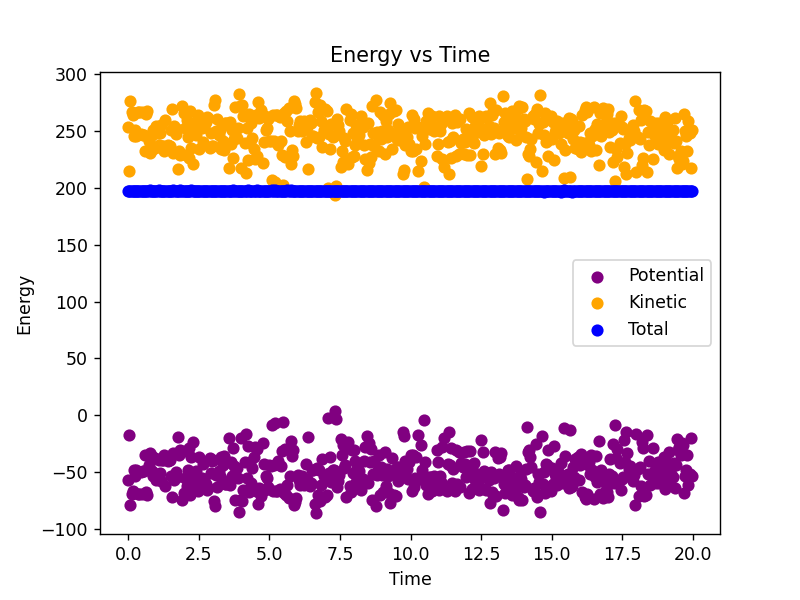

In [233]:
space = 10 # plots every given number of points. If this equals 2, it plots every point
plt.figure()
plt.scatter(time_interval[::space],U[::space],color='purple',label='Potential')
plt.scatter(time_interval[::space],ke[::space],color='orange',label='Kinetic')
plt.scatter(time_interval[::space],E[::space],color='blue',label='Total')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Energy vs Time")
plt.show()

Again, results are as expected. Total energy is still conserved and it is higher because we initially put some energy into the system. There was no time needed to find the equilibrium however. This was the point of giving the particles initial velocities; it sped up the time needed to get to that equilibrium. 

I will point out that the temperature calculated is not the initial temperature set. This is a problem with the code that I have not been able to figure out. In trying to resolve this I have noticed that the calcualted temperature and input temperature get closer if the cap for 'j' is increased in the init() function, the number of particles is increased, or both. This makes sense because the equation I'm using to calcualte that assumes there are a massive amount of particles and either averaging over more velocities or clearly having more particles improves that. However, this requires more computing time and power than my computer can handle. 

Now that we see the simulation works, we can apply it to real atoms. I will start with an example using argon because, as meantioned, the Lennord-Jones potential doesn't take bonding into consideration, so intert atoms are well represented.

The values are inputted in atomic mass units for mass, angstroms for sigma, and electron volts for epsilon and came from Elliott & Akerson's list. Initial temperature will be room temperature.

In [234]:
random.seed(100) # the seed for consistancy
nx = ny = nz = 3 # the cube will have n^3 particles
m = 39.948 # mass amu
s = 1.8887100 # sigma angstrom
e = 0.0123529 # epsilon eV
global spacing; spacing = s # particle spacing
global temp;    temp    = 293 # Initial temperature
steps = 5000 # steps to take
sys='kms' # natural vs kilogram, meter, second
initvel = 'yes' # use starting velocities. 'yes' or 'no'
constants(nx,ny,nz,m,s,e,steps,sys)
start = init(Lx,Ly,Lz,initvel)
x   = start[0]; y   = start[1]; z   = start[2] 
vx  = start[3]; vy  = start[4]; vz  = start[5]
fx0 = start[6]; fy0 = start[7]; fz0 = start[8]
fx1 = start[9]; fy1 = start[10]; fz1 = start[11]

In [235]:
U = np.zeros(len(time_interval))
ke = np.zeros(len(time_interval))
E = np.zeros(len(time_interval))
f0 = F(x,y,z)

for i in range(len(time_interval)):
    if i%100 == 0:
        aveke = mass*np.sum(vx**2+vy**2+vz**2)/(2*len(x)) # average kinetic energy
        T = 2/3 * aveke / (len(x)*kb) # Temperature of the system given by statistics
        print("Time: {:.3f}  Temp: {:.4f}  x: {:.4f}  vx: {:.4f}".format(time_interval[i], T, x[0], vx[0]))
        print('-----------------------------------------------')

    fx0 = f0[0]; fy0 = f0[1]; fz0 = f0[2]
    U[i] = f0[3]
    ke[i] = KE(vx,vy,vz)
    E[i] = U[i]+ke[i]
    nextpos(x,vx,fx0)
    nextpos(y,vy,fy0)
    nextpos(z,vz,fz0)
    boundary(x,y,z)
    f1 = F(x,y,z); fx1 = f1[0]; fy1 = f1[1]; fz1 = f1[2]
    nextvel(vx,fx1,fx0)
    nextvel(vy,fy1,fy0)
    nextvel(vz,fz1,fz0)
    f0 = np.copy(f1)
    
print('Done!')

Time: 0.000  Temp: 3.4009  x: 1.4165  vx: -148.0631
-----------------------------------------------
Time: 0.000  Temp: 3.4009  x: 1.4165  vx: -148.0631
-----------------------------------------------
Time: 0.000  Temp: 3.4009  x: 1.4165  vx: -148.0631
-----------------------------------------------
Time: 0.000  Temp: 3.4009  x: 1.4165  vx: -148.0631
-----------------------------------------------
Time: 0.000  Temp: 3.4009  x: 1.4165  vx: -148.0631
-----------------------------------------------
Time: 0.000  Temp: 3.4009  x: 1.4165  vx: -148.0631
-----------------------------------------------
Time: 0.000  Temp: 3.4009  x: 1.4165  vx: -148.0631
-----------------------------------------------
Time: 0.000  Temp: 3.4009  x: 1.4165  vx: -148.0631
-----------------------------------------------
Time: 0.000  Temp: 3.4009  x: 1.4165  vx: -148.0631
-----------------------------------------------
Time: 0.000  Temp: 3.4009  x: 1.4165  vx: -148.0631
-----------------------------------------------


<IPython.core.display.Javascript object>


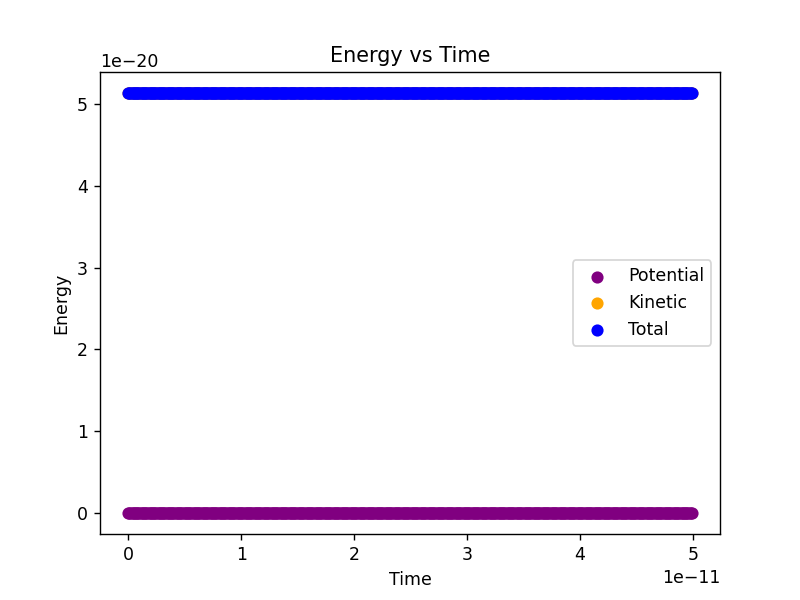

In [214]:
space = 10 # plots every given number of points. If this equals 2, it plots every point
plt.figure()
plt.scatter(time_interval[::space],U[::space],color='purple',label='Potential')
plt.scatter(time_interval[::space],ke[::space],color='orange',label='Kinetic')
plt.scatter(time_interval[::space],E[::space],color='blue',label='Total')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Energy vs Time")
plt.show()

We see that the potential energy is essentially zero the entire time and all the energy is kinetic energy. This is the usual assumption we make when talking about ideal gases, so the simulation works in that regard. Energy should still be conserved which is why it overlaps the kinetic energy.

We can pick a different element that is solid at room temperature to see how it reacts as well. I will shows chromium because both papers obtained values for it. I will be using the values from Maghfiroh, C.Y. et al. because they are given in angstroms and eVs.

In [236]:
random.seed(100) # the seed for consistancy
nx = ny = nz = 3 # the cube will have n^3 particles
m = 51.9961 # mass amu
s = 2.7813 # sigma angstrom
e = 0.24322 # epsilon eV
global spacing; spacing = s # particle spacing
global temp;    temp    = 293 # Initial temperature
steps = 5000 # steps to take
sys='kms' # natural vs kilogram, meter, second
initvel = 'yes' # use starting velocities. 'yes' or 'no'
constants(nx,ny,nz,m,s,e,steps,sys)
start = init(Lx,Ly,Lz,initvel)
x   = start[0]; y   = start[1]; z   = start[2] 
vx  = start[3]; vy  = start[4]; vz  = start[5]
fx0 = start[6]; fy0 = start[7]; fz0 = start[8]
fx1 = start[9]; fy1 = start[10]; fz1 = start[11]

In [238]:
U = np.zeros(len(time_interval))
ke = np.zeros(len(time_interval))
E = np.zeros(len(time_interval))
f0 = F(x,y,z)

for i in range(len(time_interval)):
    if i%100 == 0:
        aveke = mass*np.sum(vx**2+vy**2+vz**2)/(2*len(x)) # average kinetic energy
        T = 2/3 * aveke / (len(x)*kb) # Temperature of the system given by statistics
        print("Time: {:.3e}  Temp: {:.4f}  x: {:.4f}  vx: {:.4f}".format(time_interval[i], T, x[0], vx[0]))
        print('-----------------------------------------------')

    fx0 = f0[0]; fy0 = f0[1]; fz0 = f0[2]
    U[i] = f0[3]
    ke[i] = KE(vx,vy,vz)
    E[i] = U[i]+ke[i]
    nextpos(x,vx,fx0)
    nextpos(y,vy,fy0)
    nextpos(z,vz,fz0)
    boundary(x,y,z)
    f1 = F(x,y,z); fx1 = f1[0]; fy1 = f1[1]; fz1 = f1[2]
    nextvel(vx,fx1,fx0)
    nextvel(vy,fy1,fy0)
    nextvel(vz,fz1,fz0)
    f0 = np.copy(f1)
    
print('Done!')

Time: 0.000e+00  Temp: 3.4009  x: 2.0860  vx: -129.7804
-----------------------------------------------
Time: 1.000e-12  Temp: 3.4009  x: 2.0860  vx: -129.7804
-----------------------------------------------
Time: 2.000e-12  Temp: 3.4009  x: 2.0860  vx: -129.7804
-----------------------------------------------
Time: 3.000e-12  Temp: 3.4009  x: 2.0860  vx: -129.7804
-----------------------------------------------
Time: 4.000e-12  Temp: 3.4009  x: 2.0860  vx: -129.7804
-----------------------------------------------
Time: 5.000e-12  Temp: 3.4009  x: 2.0860  vx: -129.7804
-----------------------------------------------
Time: 6.000e-12  Temp: 3.4009  x: 2.0860  vx: -129.7804
-----------------------------------------------
Time: 7.000e-12  Temp: 3.4009  x: 2.0860  vx: -129.7804
-----------------------------------------------
Time: 8.000e-12  Temp: 3.4009  x: 2.0860  vx: -129.7804
-----------------------------------------------
Time: 9.000e-12  Temp: 3.4009  x: 2.0860  vx: -129.7804
--------

<IPython.core.display.Javascript object>


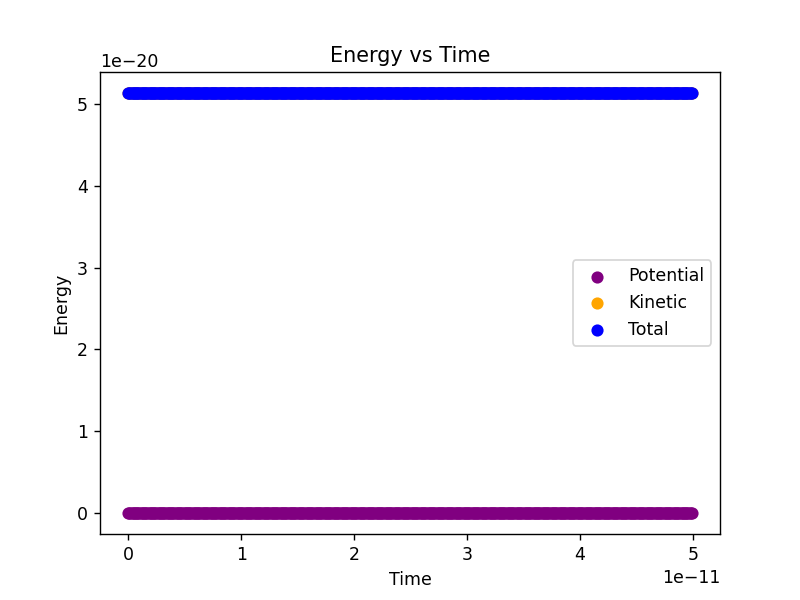

In [239]:
space = 10 # plots every given number of points. If this equals 2, it plots every point
plt.figure()
plt.scatter(time_interval[::space],U[::space],color='purple',label='Potential')
plt.scatter(time_interval[::space],ke[::space],color='orange',label='Kinetic')
plt.scatter(time_interval[::space],E[::space],color='blue',label='Total')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Energy vs Time")
plt.show()

Unfortunally in this case we don't obtain the expected result; the potential should be much higher because this is a solid. Instead, we see something similar to the argon gas simulation. In testing with other values, there was always some similar problem, so I was never able to get this part working correctly.

## Discussion

This project successfully made a molecular dynamics simulation to observe the behavior of interacting particles due to the Lennord-Jones potential. Using natural units, we can see the interactions of homogeneous particles by varying mass, $\sigma$, and $\epsilon$. As meantioned, increasing $\sigma$ made the latice stay together longer, while increaseing $\epsilon$ made it fall apart faster. This makes sense because if the particles can't get as close to eachother they will have less distance to travel between the attractive and repulsive forces, so they are more unlikely to be moved out of place enough to distrupt the latice. The effect of increasing $\epsilon$ makes sense as well because if the strength of the force is larger, then  with each oscillation more energy is being put into each particle compated to a smaller $\epsilon$. Therefore, providing a greater force each time, knocks them out of the latice sooner.

When trying to use realisitc values in SI units however, there appears to be problems. I'm not entirely sure what those problems are because the simulation is working fine in the previous case. Also, the initial temperature calculated in either case isn't equal to the initial temperature set. The Maxwell Boltzman distribution used to set the velocities assumes a huge number of particles, on the order of moles, which my computer cannot run. Therefore, the first step in a follow up investigation would be to try running this on a better computer which can handle the calculations, or have enough time to wait for this computer to finish running. I believe this is the problem because in testing when I raise the 'j' value and keep particle number the same the temperature does increase slightly. Thus, if I were able to have many particles and a large 'j' value I would expect the simulation to run properly. The appendix has graphs showing that the Maxwell-Boltzmann distribution and the potential well for argon work properly which further leads me to this conclusion.

Unfortunally, because of the problems, I was unable to find or confirm the realistic values of $\sigma$ or $\epsilon$ in any of the refreneces. Still, this appears to have been a succesful attempt, only needing more computing power and perhaps more optamization.

## Conclusion

This project set out to visualize and calculate theromodynamic quantities and $\sigma$ and $\epsilon$ values for real atoms using the Lennord-Jones potential. I implemented this using the Velocity-Verlet algorithm to calculation positions and velocities of all particles. In the end, using a small number of particles I was sucesfully able to visualize the motion and show that energy is conserved in the process for varying values of $\sigma$ and $\epsilon$. When trying to apply this to calcualte the system temperature, $\sigma$s and $\epsilon$s, I was finidng isuues with energy not being conserved and temperatures no where near the starting temperature of the system. I suspect this was due to the limited computing power availabe to me, and for further exploration into this topic increasing computing power would be the first step.

## References

[1] Elliott, R & Akerson, A (2015). Efficient 'universal' shifted Lennard-Jones model for all KIM API supported species developed by Elliott and Akerson v003, LennardJones612_UniversalShifted.params.

[2] Filippova, V.P., Kunavin, S.A., & Pugachev, M.S. (2015). Calculation of the parameters of the Lennard-Jones potential for pairs of identical atoms based on the properties of solid substances. Inorganic Materials: Applied Research, 6, 1-4.

[3] Landau, Rubin H., Manuel J. Paez, and Cristian C. Bordeianu. Computational Physics: Problem Solving with Python. Weinheim: Wiley-VCH, 2015. Print.

[4] Maghfiroh, C.Y. et al. (2019). Parameters ($\sigma$, $\epsilon$) of Lennard-Jones for Fe, Ni, Pb for Potential and Cr based on Melting Point Values Using the Molecular Dynamics Method of the Lammps Program.

## Apendix

Here are other plots that are more justification for the code running as intended and simply needing more computing power or time to accuretly simulate the interactions of particles. Below is shown for argon gas. The Maxwell-Boltamann distribution and the potential well are both as expected with the given properties.

In [54]:
random.seed(100) # the seed for consistancy
nx = ny = nz = 3 # the cube will have n^3 particles
m = 39.948 # mass amu
s = 1.8887100 # sigma angstrom
e = 0.0123529 # epsilon eV
global spacing; spacing = s # particle spacing
global temp;    temp    = 293 # Initial temperature
steps = 5000 # steps to take
sys='kms' # natural vs kilogram, meter, second
initvel = 'yes' # use starting velocities. 'yes' or 'no'
constants(nx,ny,nz,m,s,e,steps,sys)
start = init(Lx,Ly,Lz,initvel)
x   = start[0]; y   = start[1]; z   = start[2] 
vx  = start[3]; vy  = start[4]; vz  = start[5]
fx0 = start[6]; fy0 = start[7]; fz0 = start[8]
fx1 = start[9]; fy1 = start[10]; fz1 = start[11]

<IPython.core.display.Javascript object>


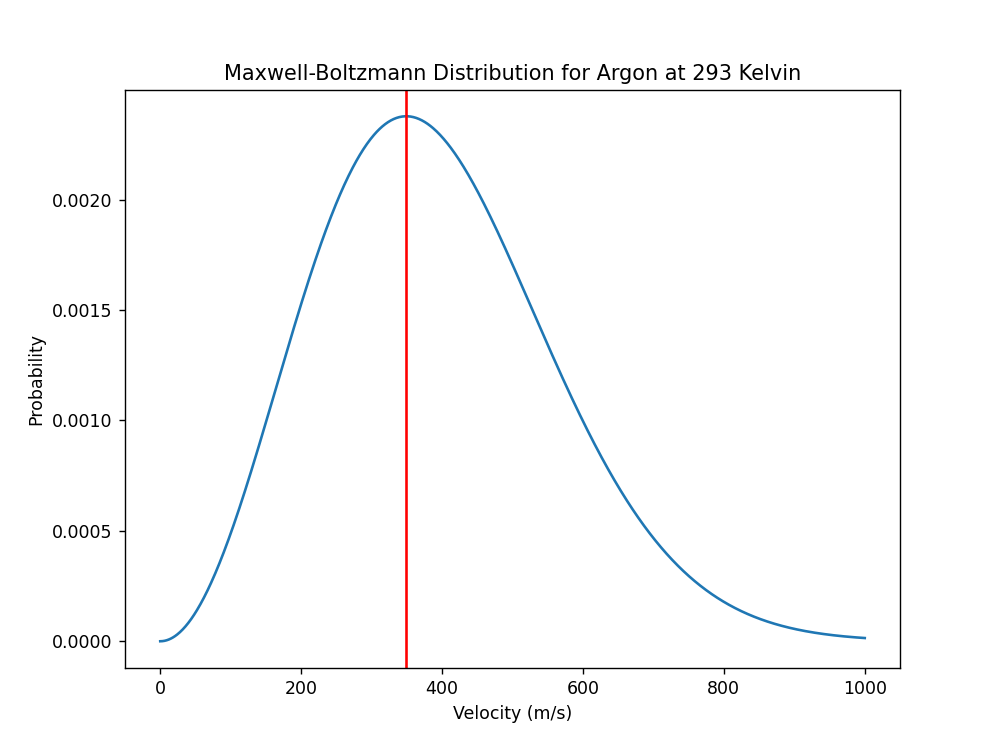

In [241]:
velocity = np.linspace(0,1000,1000)
prob = np.zeros(len(velocity))
maxv = np.sqrt(2 * kb * temp / mass)
for i in range(len(prob)):
    prob[i] = boltzmann(velocity[i])

plt.figure()
plt.plot(velocity,prob)
plt.xlabel("Velocity (m/s)")
plt.ylabel("Probability")
plt.title("Maxwell-Boltzmann Distribution for Argon at 293 Kelvin")
plt.axvline(x = maxv,color='red')
plt.show()

The red line indicates where the most probable velocity is with a value of 349.2 m/s.

<IPython.core.display.Javascript object>


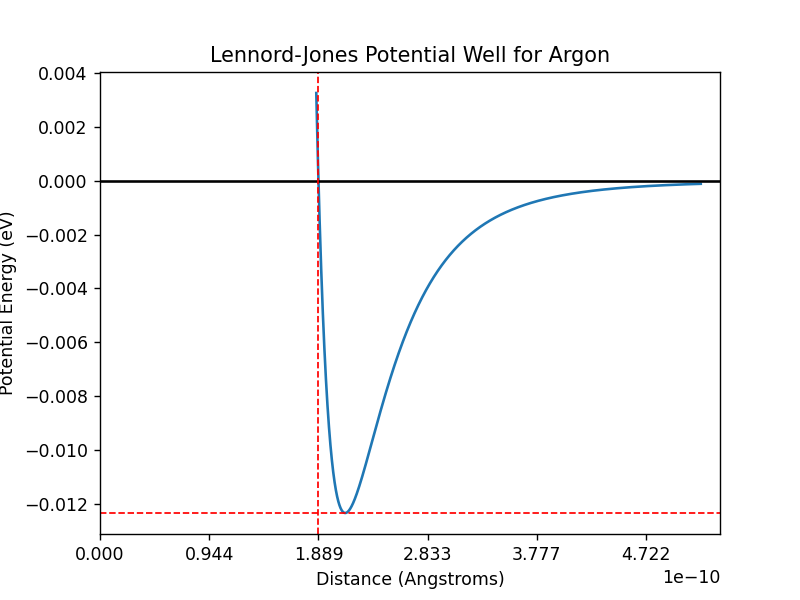

In [69]:
r = np.linspace(sig-sig/100, sig*2.75,10000)
U = np.zeros(len(r))
xticks = np.arange(0,np.max(r),sig/2)

for i in range(len(U)):
    U[i] = U[i] + 4*eps * ( (sig/r[i])**12 - (sig/r[i])**6 )

plt.figure()
plt.plot(r,((U*J).to(eV)).magnitude)
plt.axhline(y=0,color="black")
plt.xticks(xticks)
plt.xlabel("Distance (Angstroms)")
plt.ylabel("Potential Energy (eV)")
plt.title("Lennord-Jones Potential Well for Argon")
plt.axvline(x=s*10**-10,color='red',linestyle='--',linewidth=1)
plt.axhline(y=-0.0123529,color='red',linestyle='--',linewidth=1)
plt.show()

The well has the correct properties with the depth being equal to $\epsilon$ and the zero crossing at $\sigma$ shown by the dashed lines. The tick marks are every $\frac{\sigma}{2}$ and we can see the justification for the cutoff distance to be at 2.5$\sigma$ because already the potential is nearly zero.